# Livrable 4 - Livrable Technique

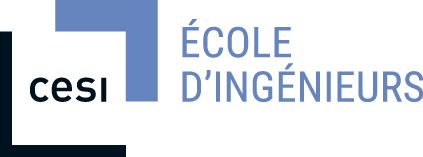

*Groupe 1 :* CAZAURANG Joana - CAIGNART Simon -  LEBLANC Lucas

## **Table des matières**



1.  [Introduction](#1)
2.  [Les Dataset](#2) \
  2.1. [Prérequis](#2.1)\
  2.2. [Fichiers d'instances](#2.2)\
  2.3. [Accès aux données](#2.3)\
    2.3.1. [Connexion à la Base de Données](#2.3.1)\
    2.3.2. [Comptage des documents présents dans la collection](#2.3.2)\
  2.4. [Code de génération aléatoire](#2.4)\
  2.5. [Valeur de l'optimal ou borne inférieure](#2.5)
3. [Analyse prédictive du trafic routier](#3)\
  3.1 [Calcul du trafic routier selon des plages horaires](#3.1)\
  3.2 [Affichage du trafic routier selon des plages horaires](#3.2)\
    3.2.1. [Affichage du trafic routier le matin](#3.2.1)\
    3.2.2. [Affichage du trafic routier le soir](#3.2.2)
4. [Algorithme utilisant les statistiques prédictives](#4)\
  4.1 [Différentes fonctions utilisés par nos algorithmes par la suite](#4.1)\
  4.2 [Algorithme glouton du plus proche voisin](#4.2)\
  4.3 [Algorithme Tabou](#4.3)\
  4.4 [Gestion du trafic](#4.4)
5. [Codes pour générer l'étude expérimentale](#5)\
  5.1 [Code de calcul des bornes inférieures](#5.1)\
    5.1.1 [Avec la méthode que nous avons vu lors d'un workshop](#5.1.1)\
    5.1.2 [Avec la librairie Ortools](#5.1.2)\
  5.2 [Code de calcul des statistiques descriptives, voire prédictives du comportement de l'algorithme](#5.2)\
    5.2.1 [Données récupérées](#5.2.1)\
    5.2.2 [Études des paramètres de l'algorithme](#5.2.2)\
    5.2.3 [Écarts de nos solutions par rapport à l'optimal en fonction du nombre de villes](#5.2.3)\
  5.3 [Script de tests de montée en charge](#5.3)
6. [Conclusion](#6)


## **1. Introduction** <a name="1"></a>

Ce projet se déroule lors du Bloc Traitement de données entre le 1er juin et le 2 juillet 2021. Ce livrable rassemble essentiellement des codes commentés afin de répondre au problème du VRP.    
Vous trouverez les explications de ces codes dans le Notebook complet via des liens de redirection. Chacun de ces codes se décompose en plusieurs parties.

## **2. Les Dataset** <a name="2"></a>

### &emsp; **2.1. Prérequis** <a name="2.1"></a>

Afin de garantir le bon fonctionnement des codes de ce livrable, il est nécessaire de mettre en place l'installation des packages avec le code ci-dessous.

In [1]:
# Installation des packages necessaires au notebook
!pip install ortools
!pip install pulp
!pip install pymongo
!pip install pylab-sdk
!pip install tabulate

import pprint
import pandas as pd
import numpy as np
import math
import time
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm
import statsmodels.stats.api as sms
import pylab as py

from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp
from statsmodels.graphics import tsaplots
from scipy import stats
from pulp import *
from random import shuffle
from random import randint
from random import randrange
from pymongo import MongoClient
from tabulate import tabulate


### &emsp; **2.2. Fichiers d'instances** <a name="2.2"></a>

&emsp; &emsp; Les fichiers d'instances utilisés dans ce projet seront la collection *vehicules_stamped* fournie dans le dernier prosit du Bloc Base de données ainsi que les données qui seront générées par le biais d'une matrice de génération de ville alléatoire, comme celle présentée dans la partie **[2.4. "Code de génération aléatoire"](#2.4)**.

### &emsp; **2.3. Accès aux données** <a name="2.3"></a>

Ce code permet de faire la connexion entre notre code python et notre base de données NoSQL sous MongoDB. Par le biai du code présenté dans [**2.3.2 "Comptage des documents présents dans la collection"**](#2.3.2) nous pouvons alors vérifier la présence des documents dans la collection étudiée.

#### &emsp; &emsp; **2.3.1. Connexion à la Base de Données** <a name="2.3.1"></a>

Dans le code ci-dessous se trouve la connexion à notre base de données MongoDB qui se trouve en local.

In [2]:
client = MongoClient('localhost', 27017) #connexion vers l'instance du client "localhost" qui se trouve sur le port 27017
db = client['DataProject'] #Nom de la base de données étudiée
collection_trafic_stamped = db['vehicules_stamped'] #Nom de la collection étudiée

 #### &emsp; &emsp; **2.3.2. Comptage des documents présents dans la collection** <a name="2.3.2"></a>

Avec le code ci-dessous nous pouvons vérifier le nombre de documents présents dans la collection "*vehicules_stamped*".

In [3]:
collection_trafic_stamped = db['vehicules_stamped']
#calcul et print le nombre de documents
print ("Il y a ", db.vehicules_stamped.estimated_document_count(), " documents dans la base de données.")

Il y a  600000  documents dans la base de données.


### &emsp; **2.4. Code de génération aléatoire** <a name="2.4"></a>

Nous avons mis en place un algorithme permettant de générer dans une matrice des temps de manière aléatoire.  

Cela à pour but de générer, pour *n* villes, une matrice possédant pour temps maximum *t* minutes. De plus, nous avons mis en place un calcul du temps d'exécution afin de favoriser la performance et la rapidité de l'algorithme.


In [4]:
# Modifier ces paramètres pour modifier le nombre de villes dans la matrice et le temps maximum séparant deux villes
nb_villes=10
tempsMax=200

def grapheVillesAleatoire(nbVilles, tempsMax):
    #La fonction créait une matrice donnant le temps entre chaque ville de manière aléatoire.
    graphe = np.random.choice(range(5,tempsMax), size=(nbVilles,nbVilles))
    for i in range(nbVilles): #La boucle s'exécute pour chaque ville (nbVilles) et ajoute la valeur dans la matrice
        graphe[i][i]= 0      
    grapheF = ((graphe + graphe.T - np.diag(graphe.diagonal()))/2).astype(int)
    return grapheF


start = time.time() #Commence à calculer le temps d'exécution
graphe = grapheVillesAleatoire(nb_villes,tempsMax) #Génère une matrice pour n villes (exemple:10) et ayant pour temps max. t minutes (exemple:200)
print(graphe)
stop = time.time() #Stop le calcul du temps d'exécution

print("\nTemps total d'exécution: " + str(stop-start) + " secondes")

[[  0 117  92 180  61  91 172  90  38 169]
 [117   0  31  77  34 143  85  56 105  82]
 [ 92  31   0 155 105 156 163 100 137  84]
 [180  77 155   0 148  82  80 129 154 139]
 [ 61  34 105 148   0  71  49 140 158 134]
 [ 91 143 156  82  71   0 131  80  96  67]
 [172  85 163  80  49 131   0 105 160 103]
 [ 90  56 100 129 140  80 105   0  50  98]
 [ 38 105 137 154 158  96 160  50   0 151]
 [169  82  84 139 134  67 103  98 151   0]]

Temps total d'exécution: 0.003161907196044922 secondes


### &emsp; **2.5. Valeur de l'optimal ou borne inférieure** <a name="2.5"></a>

La valeur optimale ou borne inférieure de notre problème correspond au chemin possédant le temps de trajet le plus court possible. Afin de calculer cette valeur, nous avons utilisé la programmation linéaire, voir partie [**5.1 "Code de calcul des bornes inférieures"**](#5.1).

## **3. Analyse prédictive du trafic routier**  <a name="3"></a>

Cette analyse est basée sur une journée et sur le trafic uniquement entre deux villes. Plusieurs chemins sont malgré tout empruntables.
Cette partie vous sera expliquée dans la partie **[3.1 "Conception d'un modèle statistique pour la prédiction de trafic routier"](https://colab.research.google.com/drive/11_crf9loEv5Ln02x2T5DBxnaA_km9XBz#scrollTo=9fUDkP5Oicbk&line=1&uniqifier=1)** du Notebook Complet.

### &emsp; **3.1. Calcul du trafic routier selon des plages horaires**  <a name="3.1"></a>

In [5]:
#Calcul du nombre de véhicules sur les axes routiers le matin
vehicules_par_arete_matin = list(db.vehicules_stamped.aggregate([
    {"$project":{"num_arete":1, "heures":{"$hour":"$date"}, "nb_vehicules":1}}, #Commence par formater les données à analyser
    {"$match":{"heures":{"$lte":9, "$gte":7}}}, #paramètres de recherches dans la plage horaire
    {"$group":{"_id":"$num_arete",
               "nb_vehicules":{"$avg":"$nb_vehicules"}}}, 
    {"$sort":{"nb_vehicules":-1}} #trier par ordre décroissant
]))

print("Le résultat retourné pour la plage matinale :")
print("\n L'arête la plus congestionnée :", vehicules_par_arete_matin[0],
      "\n L'arête médianne :", vehicules_par_arete_matin[249], 
      "\n L'arête la moins congestionnée :", vehicules_par_arete_matin[-1])

Le résultat retourné pour la plage matinale :

 L'arête la plus congestionnée : {'_id': 111, 'nb_vehicules': 78.13} 
 L'arête médianne : {'_id': 461, 'nb_vehicules': 65.57833333333333} 
 L'arête la moins congestionnée : {'_id': 132, 'nb_vehicules': 52.675}


In [6]:
#Calcul du nombre de véhicules sur les axes routiers le soir
vehicules_par_arete_soir = list(db.vehicules_stamped.aggregate([
    {"$project":{"num_arete":1, "heures":{"$hour":"$date"}, "nb_vehicules":1}}, #Commence par formater les données à analyser
    {"$match":{"heures":{"$lte":19, "$gte":17}}}, #paramètres de recherches dans la plage horaire
    {"$group":{"_id":"$num_arete",
               "nb_vehicules":{"$avg":"$nb_vehicules"}}}, 
    {"$sort":{"nb_vehicules":-1}} #trier par ordre décroissant
]))

print("Le résultat retourné pour la plage nocturne :")
print("\n L'arête la plus congestionnée :", vehicules_par_arete_soir[0],
      "\n L'arête médianne :", vehicules_par_arete_soir[249], 
      "\n L'arête la moins congestionnée :", vehicules_par_arete_soir[-1])

Le résultat retourné pour la plage nocturne :

 L'arête la plus congestionnée : {'_id': 419, 'nb_vehicules': 107.27666666666667} 
 L'arête médianne : {'_id': 175, 'nb_vehicules': 93.79666666666667} 
 L'arête la moins congestionnée : {'_id': 296, 'nb_vehicules': 81.54666666666667}


### &emsp; **3.2. Affichage du trafic routier selon des plages horaires**  <a name="3.2"></a>

#### &emsp; &emsp; **3.2.1. Affichage du trafic routier le matin**  <a name="3.2.1"></a>

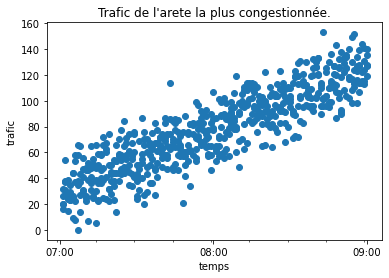

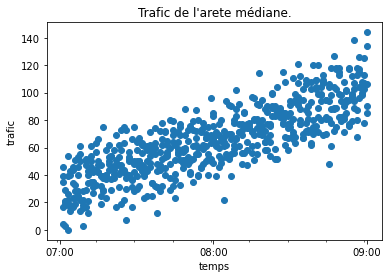

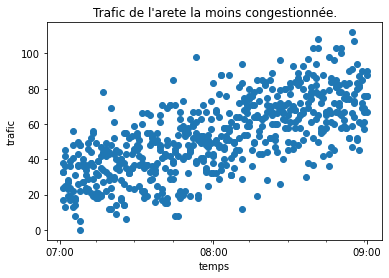

In [7]:
#Ce code permet l'affichage de l'encombrement des voies le matin (max, min et médiane)
arete_mediane = vehicules_par_arete_matin[249]["_id"]
arete_max, arete_min = vehicules_par_arete_matin[0]["_id"], vehicules_par_arete_matin[-1]["_id"]

#Calcul du nombre de véhicules sur les axes routiers par heure
vehicules_arete_mediane_matin = db.vehicules_stamped.aggregate([
    {"$match":{"num_arete":{"$eq":arete_mediane}}}, #récupère les données nécessaires
    {"$project":{"temps":{"heures":{"$hour":"$date"}, #Commence par formater les données à analyser
                          "minutes":{"$minute":"$date"}},
                "nb_vehicules":1}}, 
    {"$match":{"temps.heures":{"$lte":9, "$gte":7}}}, #paramètres de recherches dans la plage horaire
     {"$sort":{"temps":1}}])  #trier par ordre croissant
vehicules_arete_max_matin = db.vehicules_stamped.aggregate([
    {"$match":{"num_arete":{"$eq":arete_max}}}, #récupère les données nécessaires
    {"$project":{"temps":{"heures":{"$hour":"$date"}, #Commence par formater les données à analyser
                          "minutes":{"$minute":"$date"}}, 
                "nb_vehicules":1}},  
    {"$match":{"temps.heures":{"$lte":9, "$gte":7}}}, #paramètres de recherches dans la plage horaire
     {"$sort":{"temps":1}}]) #trier par ordre croissant
vehicules_arete_min_matin = db.vehicules_stamped.aggregate([
    {"$match":{"num_arete":{"$eq":arete_min}}}, #récupère les données nécessaires
    {"$project":{"temps":{"heures":{"$hour":"$date"},  #Commence par formater les données à analyser
                          "minutes":{"$minute":"$date"}}, 
                "nb_vehicules":1}}, 
    {"$match":{"temps.heures":{"$lte":9, "$gte":7}}}, #paramètres de recherches dans la plage horaire
     {"$sort":{"temps":1}}]) #trier par ordre croissant

 

# Traitements relatif a l'arete la plus congestionnée
# Extraction des dates
xs = \
    pd.date_range("2020-01-01 07:01", "2020-01-01 09:00", freq = "min").to_pydatetime().tolist()
# Duplication des dates sur les 5 jours suivants
xs = \
    [e for sub in zip(xs, xs, xs, xs, xs) for e in sub]  
# Données de trafic pour l'arete la plus congestionnée
trafics = \
    [trafic["nb_vehicules"] for trafic in vehicules_arete_max_matin] 
# Données matinales
ys = \
    trafics[:600] #correspond aux 10h de plages traitées
# Affichage relatif a l'arete la plus congestionnée
fig, ax = plt.subplots() 
ax.xaxis.set_major_locator(mdates.HourLocator(interval = 1)) 
ax.xaxis.set_minor_locator(mdates.MinuteLocator(interval = 15)) 
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M')) 
ax.set(title="Trafic de l'arete la plus congestionnée.", xlabel="temps", ylabel="trafic") 
ax.plot(xs,ys,"o")


# Traitements relatif a l'arete médiane
trafics = \
    [trafic["nb_vehicules"] for trafic in vehicules_arete_mediane_matin] 
ys = \
    trafics[:600] 
# Affichage relatif a l'arete médiane
fig, ax = plt.subplots() 
ax.xaxis.set_major_locator(mdates.HourLocator(interval = 1)) 
ax.xaxis.set_minor_locator(mdates.MinuteLocator(interval = 15)) 
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M')) 
ax.set(title="Trafic de l'arete médiane.", xlabel="temps", ylabel="trafic") 
ax.plot(xs,ys,"o") 

 
# Traitements relatif a l'arete la moins congestionnée
trafics = \
    [trafic["nb_vehicules"] for trafic in vehicules_arete_min_matin] 
ys = \
    trafics[:600] 
# Affichage relatif a l'arete la moins congestionnée
fig, ax = plt.subplots() 
ax.xaxis.set_major_locator(mdates.HourLocator(interval = 1)) 
ax.xaxis.set_minor_locator(mdates.MinuteLocator(interval = 15)) 
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M')) 
ax.set(title="Trafic de l'arete la moins congestionnée.", xlabel="temps", ylabel="trafic") 
ax.plot(xs,ys,"o") 

#affiche les différents nuages de points
plt.show()

##### &emsp; &emsp; &emsp; ***3.2.1.1. Régression linéaire du trafic matinal***

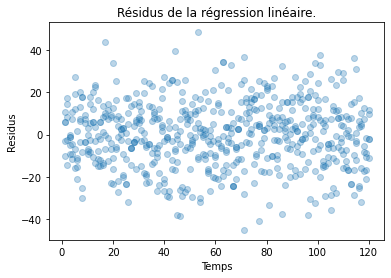

In [8]:
# En premier lieu le modèle devra être entrainé avant de l'évaluer
# Les données au format date sont converties en minutes
X = [(date.hour-7)*60+date.minute for date in xs]
# Ajout de la colonne correspondant à la constante
X = \
    np.append(arr = np.ones((len(X), 1)).astype(int), values = np.array([X]).T, axis = 1) 
# Entrainement du modèle
regressor_OLS = \
    sm.OLS(endog = ys, exog = X).fit()
# Predictions avec le modèle
y_pred = \
    regressor_OLS.params[0]+regressor_OLS.params[1]*X[:,1] 

# Affichage des résidus dans un graphe
fig, ax = plt.subplots()
ax.scatter(X[:,1], #Les résidus
           regressor_OLS.resid, alpha=0.3)
ax.set(title="Résidus de la régression linéaire.", xlabel="Temps", ylabel="Residus")
plt.show()


##### &emsp; &emsp; &emsp; ***3.2.1.2. Test la normalité des résidus***

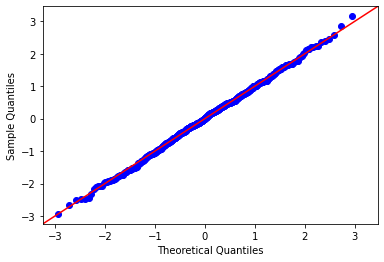

In [9]:
#Test de la normalité des résidus obtenus 

sm.qqplot(regressor_OLS.resid_pearson, fit=True , line ='45') #tracer des quantiles des résidus
plt.show() #création du graphe

##### &emsp; &emsp; &emsp; ***3.2.1.3. Autocorrélation des résidus***

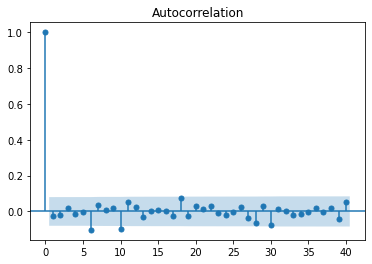

Resultat du test d'auto-correlation (H0 : pas d'autocorrelation)
      lb_stat  lb_pvalue
1    0.392752   0.530857
2    0.682970   0.710714
3    0.906116   0.823952
4    1.052310   0.901763
5    1.058345   0.957724
6    7.528268   0.274739
7    8.415887   0.297353
8    8.483382   0.387730
9    8.716628   0.463832
10  14.388969   0.155977
11  16.008180   0.140827
12  16.324294   0.176830
13  16.986780   0.199909
14  16.997960   0.256287
15  17.039871   0.316486
16  17.040062   0.383009
17  17.466032   0.423250
18  20.844186   0.287347
19  21.331922   0.318754
20  22.008774   0.340035
21  22.146613   0.391104
22  22.659993   0.421136
23  22.685047   0.479283
24  22.885322   0.526576
25  22.888297   0.584086
26  23.285810   0.616732
27  24.177023   0.620479
28  26.938893   0.521577
29  27.474768   0.546107
30  31.296051   0.400959
31  31.399292   0.446228
32  31.415050   0.496006
33  31.700905   0.531725
34  31.791504   0.576304
35  31.806466   0.623073
36  32.069968   0.656073
37  32.074

/Users/simon/opt/anaconda3/lib/python3.8/site-packages/statsmodels/stats/diagnostic.py:531: FutureWarning: The default value of lags is changing.  After 0.12, this value will become min(10, nobs//5). Directly setlags to silence this warning.
  warnings.warn("The default value of lags is changing.  After 0.12, "


In [10]:
# Affichage de la fonction d'autocorrelation

#Tracer les erreurs sur l'horizontale et les corrélations sur l'axe vertical.
fig = tsaplots.plot_acf(regressor_OLS.resid, lags=40) 
plt.show()#création du graphe

print("Resultat du test d'auto-correlation (H0 : pas d'autocorrelation)")
print(sm.stats.acorr_ljungbox(regressor_OLS.resid, return_df=True))

##### &emsp; &emsp; &emsp; ***3.2.1.4. Evaluation de la régression linéaire***

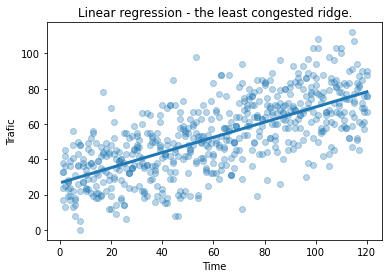

Evaluation de la regression lineaire en utilisant la classe statsmodels :
Les parametres de la regression sont  [26.66722689  0.42988055]
La valeur du coefficient de détermination est  0.48314287642084675


In [11]:
fig, ax = plt.subplots()

# Affichage du nuage de point avec une légende
ax.scatter(X[:,1], ys, alpha=0.3) 
ax.set(title="Linear regression - the least congested ridge.", xlabel="Time", ylabel="Trafic")

# Affichage de la droite d'ajustement
ax.plot(X[:,1], y_pred, linewidth=3) 

#création du graphe
plt.show()

print("Evaluation de la regression lineaire en utilisant la classe statsmodels :")
print("Les parametres de la regression sont ", 
      regressor_OLS.params)
print("La valeur du coefficient de détermination est ", 
      regressor_OLS.rsquared)

#### &emsp; &emsp; **3.2.2. Affichage du trafic routier le soir**  <a name="3.2.2"></a>

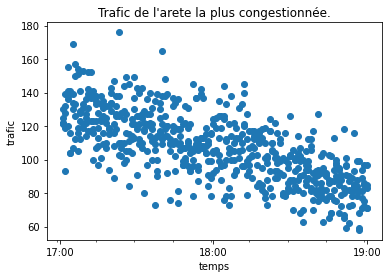

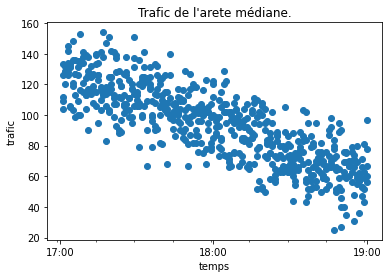

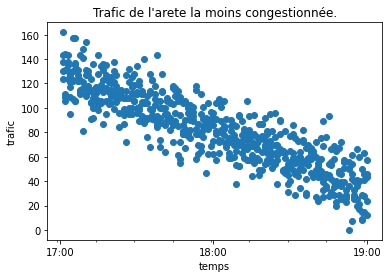

In [12]:
#Ce code permet l'affichage de l'encombrement des voies le soir (max, min et médiane)
arete_mediane = vehicules_par_arete_soir[249]["_id"]
arete_max, arete_min = vehicules_par_arete_soir[0]["_id"], vehicules_par_arete_soir[-1]["_id"]

#Calcul du nombre de véhicules sur les axes routiers par heure
vehicules_arete_mediane_soir = db.vehicules_stamped.aggregate([
    {"$match":{"num_arete":{"$eq":arete_mediane}}}, #récupère les données nécessaires
    {"$project":{"temps":{"heures":{"$hour":"$date"}, #Commence par formater les données à analyser
                          "minutes":{"$minute":"$date"}},
                "nb_vehicules":1}}, 
    {"$match":{"temps.heures":{"$lte":19, "$gte":17}}}, #paramètres de recherches dans la plage horaire
     {"$sort":{"temps":1}}])  #trier par ordre croissant
vehicules_arete_max_soir = db.vehicules_stamped.aggregate([
    {"$match":{"num_arete":{"$eq":arete_max}}}, #récupère les données nécessaires
    {"$project":{"temps":{"heures":{"$hour":"$date"}, #Commence par formater les données à analyser
                          "minutes":{"$minute":"$date"}}, 
                "nb_vehicules":1}},  
    {"$match":{"temps.heures":{"$lte":19, "$gte":17}}}, #paramètres de recherches dans la plage horaire
     {"$sort":{"temps":1}}]) #trier par ordre croissant
vehicules_arete_min_soir = db.vehicules_stamped.aggregate([
    {"$match":{"num_arete":{"$eq":arete_min}}}, #récupère les données nécessaires
    {"$project":{"temps":{"heures":{"$hour":"$date"},  #Commence par formater les données à analyser
                          "minutes":{"$minute":"$date"}}, 
                "nb_vehicules":1}}, 
    {"$match":{"temps.heures":{"$lte":19, "$gte":17}}}, #paramètres de recherches dans la plage horaire
     {"$sort":{"temps":1}}]) #trier par ordre croissant

 

# Traitements relatif a l'arete la plus congestionnée
# Extraction des dates
xs = \
    pd.date_range("2020-01-01 17:01", "2020-01-01 19:00", freq = "min").to_pydatetime().tolist()
# Duplication des dates sur les 5 jours suivants
xs = \
    [e for sub in zip(xs, xs, xs, xs, xs) for e in sub]  
# Données de trafic pour l'arete la plus congestionnée
trafics = \
    [trafic["nb_vehicules"] for trafic in vehicules_arete_max_soir] 
# Données matinales
ys = \
    trafics[:600] #correspond aux 10h de plages traitées
# Affichage relatif a l'arete la plus congestionnée
fig, ax = plt.subplots() 
ax.xaxis.set_major_locator(mdates.HourLocator(interval = 1)) 
ax.xaxis.set_minor_locator(mdates.MinuteLocator(interval = 15)) 
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M')) 
ax.set(title="Trafic de l'arete la plus congestionnée.", xlabel="temps", ylabel="trafic") 
ax.plot(xs,ys,"o")


# Traitements relatif a l'arete médiane
trafics = \
    [trafic["nb_vehicules"] for trafic in vehicules_arete_mediane_soir] 
ys = \
    trafics[:600] 
# Affichage relatif a l'arete médiane
fig, ax = plt.subplots() 
ax.xaxis.set_major_locator(mdates.HourLocator(interval = 1)) 
ax.xaxis.set_minor_locator(mdates.MinuteLocator(interval = 15)) 
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M')) 
ax.set(title="Trafic de l'arete médiane.", xlabel="temps", ylabel="trafic") 
ax.plot(xs,ys,"o") 

 
# Traitements relatif a l'arete la moins congestionnée
trafics = \
    [trafic["nb_vehicules"] for trafic in vehicules_arete_min_soir] 
ys = \
    trafics[:600] 
# Affichage relatif a l'arete la moins congestionnée
fig, ax = plt.subplots() 
ax.xaxis.set_major_locator(mdates.HourLocator(interval = 1)) 
ax.xaxis.set_minor_locator(mdates.MinuteLocator(interval = 15)) 
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M')) 
ax.set(title="Trafic de l'arete la moins congestionnée.", xlabel="temps", ylabel="trafic") 
ax.plot(xs,ys,"o") 

#affiche les différents nuages de points
plt.show()

##### &emsp; &emsp; &emsp; ***3.2.2.1. Régression linéaire du trafic le soir***

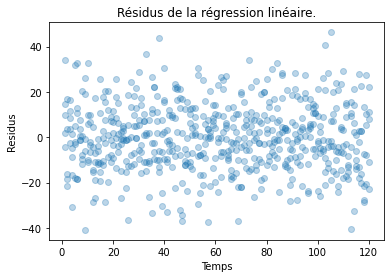

In [13]:
# En premier lieu le modèle devra être entrainé avant de l'évaluer
# Les données au format date sont converties en minutes
X = [(date.hour-17)*60+date.minute for date in xs]
# Ajout de la colonne correspondant à la constante
X = \
    np.append(arr = np.ones((len(X), 1)).astype(int), values = np.array([X]).T, axis = 1) 
# Entrainement du modèle
regressor_OLS = \
    sm.OLS(endog = ys, exog = X).fit()
# Predictions avec le modèle
y_pred = \
    regressor_OLS.params[0]+regressor_OLS.params[1]*X[:,1] 

# Affichage des résidus dans un graphe
fig, ax = plt.subplots()
ax.scatter(X[:,1], #Les résidus
           regressor_OLS.resid, alpha=0.3)
ax.set(title="Résidus de la régression linéaire.", xlabel="Temps", ylabel="Residus")
plt.show()


##### &emsp; &emsp; &emsp; ***3.2.2.2. Test la normalité des résidus***

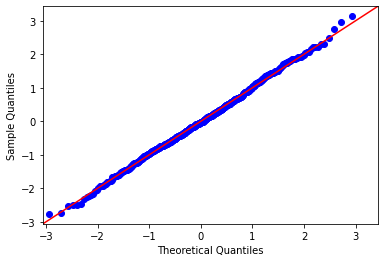

In [14]:
#Test de la normalité des résidus obtenus 

sm.qqplot(regressor_OLS.resid_pearson, fit=True , line ='45') #tracer des quantiles des résidus
plt.show() #création du graphe

##### &emsp; &emsp; &emsp; ***3.2.2.3. Autocorrélation des résidus***

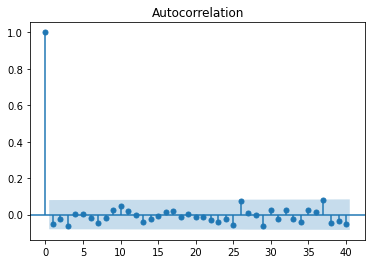

Resultat du test d'auto-correlation (H0 : pas d'autocorrelation)
      lb_stat  lb_pvalue
1    1.605367   0.205144
2    2.001652   0.367576
3    4.336127   0.227381
4    4.339496   0.362005
5    4.360098   0.498817
6    4.547729   0.602981
7    5.956700   0.544814
8    6.225064   0.622037
9    6.629813   0.675599
10   7.973303   0.631445
11   8.168427   0.698142
12   8.169825   0.771722
13   9.133411   0.762795
14   9.453029   0.800982
15   9.487597   0.850675
16   9.649509   0.884280
17   9.892428   0.908061
18  10.033659   0.930802
19  10.056041   0.951550
20  10.144070   0.965484
21  10.262513   0.975298
22  10.730952   0.978379
23  11.732146   0.974399
24  12.126074   0.978450
25  13.998362   0.961761
26  17.642061   0.888405
27  17.684152   0.912877
28  17.697283   0.933519
29  20.306669   0.883139
30  20.784141   0.894516
31  21.112863   0.908901
32  21.528440   0.919438
33  21.814080   0.931663
34  22.829169   0.927407
35  23.257108   0.935573
36  23.372084   0.948291
37  27.392

/Users/simon/opt/anaconda3/lib/python3.8/site-packages/statsmodels/stats/diagnostic.py:531: FutureWarning: The default value of lags is changing.  After 0.12, this value will become min(10, nobs//5). Directly setlags to silence this warning.
  warnings.warn("The default value of lags is changing.  After 0.12, "


In [15]:
# Affichage de la fonction d'autocorrelation

#Tracer les erreurs sur l'horizontale et les corrélations sur l'axe vertical.
fig = tsaplots.plot_acf(regressor_OLS.resid, lags=40) 
plt.show()#création du graphe

print("Resultat du test d'auto-correlation (H0 : pas d'autocorrelation)")
print(sm.stats.acorr_ljungbox(regressor_OLS.resid, return_df=True))

##### &emsp; &emsp; &emsp; ***3.2.2.4. Evaluation de la régression linéaire***

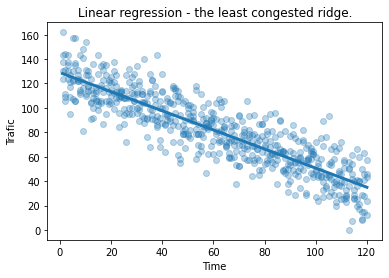

Evaluation de la regression lineaire en utilisant la classe statsmodels :
Les parametres de la regression sont  [128.91927171  -0.78301827]
La valeur du coefficient de détermination est  0.7713054547459957


In [16]:
fig, ax = plt.subplots()

# Affichage du nuage de point avec une légende
ax.scatter(X[:,1], ys, alpha=0.3) 
ax.set(title="Linear regression - the least congested ridge.", xlabel="Time", ylabel="Trafic")

# Affichage de la droite d'ajustement
ax.plot(X[:,1], y_pred, linewidth=3) 

#création du graphe
plt.show()

print("Evaluation de la regression lineaire en utilisant la classe statsmodels :")
print("Les parametres de la regression sont ", 
      regressor_OLS.params)
print("La valeur du coefficient de détermination est ", 
      regressor_OLS.rsquared)

## **4. Algorithme utilisant les statistiques prédictives**  <a name="4"></a>

### &emsp; &emsp;  **4.1 Différentes fonctions utilisées par nos algorithmes par la suite**  <a name="4.1"></a>

In [17]:
def get_neighbors(path, graphe):
    """
    Cette fonction est un générateur de tous les voisins valides d'une solution
    
    Exemple:
    0,1,2,3,0
    
    0,2,1,3,0    
    0,3,2,1,0
    0,1,3,2,0

    """ 
    # On supprime le point de départ et d'arrivé pour ne pas les échangés
    start_node = path.pop(0)
    path.pop(len(path)-1)
    index=0
    for i in range(len(path)):
        for j in range(1,len(path)-i):
            neighbor_path=path.copy()
            neighbor_path[i], neighbor_path[i+j] = neighbor_path[i+j], neighbor_path[i]
            # On rajoute le point de départ et d'arrivé avant de renvoyer le chemin
            neighbor_path.insert(0,start_node)
            neighbor_path.append(start_node)
            yield(neighbor_path)

# Test simple de la fonction
for voisin in get_neighbors([0,1,2,3,0],graphe):
    print(voisin)

[0, 2, 1, 3, 0]
[0, 3, 2, 1, 0]
[0, 1, 3, 2, 0]


In [18]:
def get_path_cost(path, graphe):
    """
    Cette fonction renvoie le coût total d'un chemin, dans notre cas, le temps en minutes pour le parcourir
    """
    cost=0
    for i in range(len(path)-1):
        cost+=graphe[path[i]][path[i+1]]
    return cost

In [19]:
cities=["la rochelle","rochefort","saint-agnant","pouillat","torcieu","replonges","corcelles","peron","relevant","chaveyriat","vaux-en-bugey","maillat","faramans","beon","saint-bernard","rossillon","pont-d-ain","nantua","chavannes-sur-reyssouze","neuville-les-dames","flaxieu","hotonnes","saint-sorlin-en-bugey","songieu","virieu-le-petit","saint-denis-en-bugey","charnoz-sur-ain","chazey-sur-ain","marchamp","culoz","mantenay-montlin","marboz","foissiat","treffort-cuisiat","izieu","saint-etienne-du-bois","hauteville-lompnes","saint-trivier-sur-moignans","peyriat","evosges","poncin","crans","montreal-la-cluse","cleyzieu","lompnieu","villereversure","saint-martin-du-mont","saint-genis-pouilly","bolozon","tarnos","lochieu","chanoz-chatenay","villebois","ceignes","saint-didier-sur-chalaronne","revonnas","bourg-saint-christophe","condeissiat","pirajoux","chalamont","plantay","versailleux","montagnat","vieu","saint-andre-de-corcy","landerneau","peronnas","colomieu","monthieux","saint-jean-sur-reyssouze","saint-agnant","montrevel-en-bresse","conand","challes-la-montagne","mogneneins","thoissey","chaleins","neuville-sur-ain","thil","jujurieux","oncieu","lurcy","balan","ambutrix","sainte-croix","blyes","conzieu","nievroz","nurieux-volognat","ambleon","saint-maurice-de-gourdans","chezery-forens","sault-brenaz","murs-et-gelignieux","petit-abergement","cormoz","saint-martin-de-bavel","saint-trivier-de-courtes","boyeux-saint-jerome","chateau-gaillard"]

'''
Cette fonction permet de renvoyer le chemin avec des nom de villes à partir du chemin avec des index
'''
def indexToCities(path):
    if len(path) <= len(cities):
        pathWithCities=list()
        for city in path:
            pathWithCities.append(cities[city])
    else:
        pathWithCities=path
    return pathWithCities

### &emsp; &emsp; **4.2 Algorithme glouton du plus proche voisin**  <a name="4.2"></a>

Cet algorithme permet de trouver un chemin valide très rapidement, avec une solution plutôt proche de l'optimal. Nous l'utilisons par la suite dans notre algorithme tabou pour déterminer le chemin initial.

In [20]:
def next_city(current_city_index,visited_cities_indexes,graphe) :
#La fonction donne l'indice de la ville la plus proche de celle d'indice actuel et qui n'a pas été visitée.
    mini = 1000000000
    minimum_index = -1
    for i in range(len(graphe)) :
        if visited_cities_indexes[i] == False :
            if graphe[current_city_index][i] < mini :
                mini = graphe[current_city_index][i]
                minimum_index = i
    return minimum_index

def nearest_neighbor(start_city,graphe):
    """ La fonction donne le chemin a suivre du voyageur de commerce sous forme d'un tableau d'indice."""
    visited_cities_indexes = [False] * len(graphe) # Au départ les villes ne sont pas visitées
    path = [0]* (len(graphe)) # Le chemin du voyageur au départ est vide.

    current_city_index = start_city # On trouve l'indice de la ville
    visited_cities_indexes[current_city_index] = True # On dit que la ville est visitée.
    path[0] = current_city_index

    for i in range(1,len(graphe)) :
        indice_next_city= next_city(current_city_index,visited_cities_indexes,graphe)
        path[i] = indice_next_city
        current_city_index = indice_next_city
        visited_cities_indexes[current_city_index] = True # La ville est visitée elle ne peut plus être prise.
    path.append(path[0])
    return path

res_nearest_neighbor=nearest_neighbor(0,graphe)

print("\nChemin avec l'algorithme du plus proche voisin : " + str(res_nearest_neighbor))
print("")
print("Valeur de ce chemin : " + str(get_path_cost(res_nearest_neighbor,graphe)))


Chemin avec l'algorithme du plus proche voisin : [0, 8, 7, 1, 2, 9, 5, 4, 6, 3, 0]

Valeur de ce chemin : 706


### &emsp; &emsp;  **4.3 Algorithme Tabou**  <a name="4.3"></a>

L'algorithme de recherche tabou est notre algorithme principal. Il nous permet d'obtenir de bons résultats, proches de la borne inférieure. La spécificité de notre mise en oeuvre est l'utilisation du résultat de l'algorithme du plus proche voisin en tant que chemin initial. Le tabou commence alors directement à une valeur plutôt proche de l'optimal, et essaye de l'améliorer. Cette technique nous permet de gagner du temps et d'éviter des itérations inutiles.

La valeur du chemin initial est : 1557

---------------------------------------------

Le meilleur chemin trouvé est : ['la rochelle', 'flaxieu', 'marchamp', 'relevant', 'foissiat', 'pont-d-ain', 'saint-denis-en-bugey', 'nantua', 'rossillon', 'saint-agnant', 'mantenay-montlin', 'saint-sorlin-en-bugey', 'culoz', 'chaveyriat', 'chavannes-sur-reyssouze', 'neuville-les-dames', 'faramans', 'hotonnes', 'torcieu', 'songieu', 'pouillat', 'rochefort', 'treffort-cuisiat', 'saint-bernard', 'corcelles', 'replonges', 'maillat', 'evosges', 'izieu', 'hauteville-lompnes', 'chazey-sur-ain', 'saint-etienne-du-bois', 'peyriat', 'marboz', 'peron', 'beon', 'virieu-le-petit', 'vaux-en-bugey', 'charnoz-sur-ain', 'saint-trivier-sur-moignans', 'la rochelle']

Sa valeur est de : 1503 mn, soit 25.05 h

Temps d'execution : 7.022303104400635 secondes




Text(0.5, 1.0, '\nExploration de la zone de recherche par notre algorithme\n')

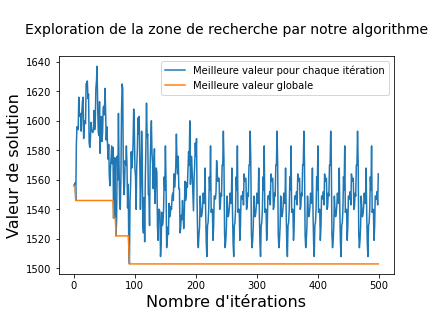

In [21]:
def tabu_search(start_node, tabu_length, iter_max, graphe, withNearestNeighbor):
    """
    1. On part d'un element de notre ensemble de recherche qu'on declare element courant
    2. On considere le voisinage de l'element courant et on choisit le  meilleur d'entre
       eux comme nouvel element courant, parmi ceux absents de la liste tabou, et on l'ajoute
       a la liste tabou
    3. On boucle jusqu'a condition de sortie.
    """

    #Conversion de la ville de départ en index
    try:
        start_node=cities.index(start_node)
    except:
        print("Cette ville n'est pas présente dans le graphe, utilisation de la ville par défaut (la rochelle)\n")
        start_node=cities.index("la rochelle")
        
    nb_iter = 0
    tabu_list = list()

    # Ici on utilise comme chemin initiale le résultat de notre algorithme du plus proche voisin
    if withNearestNeighbor==True:
        initial_element=nearest_neighbor(start_node,graphe)
    #On peut également utiliser un chemin initial aléatoire, pour cela, il faut décommenter les 2 lignes ci dessous et commenter la ligne du dessus
    else:
        initial_element=[i for i in range(len(graphe))]
        initial_element.remove(start_node)
        initial_element.append(start_node)
        initial_element.insert(0,start_node)
        
    # variables solutions pour la recherche du voisin optimal non tabou
    current_element = initial_element
    best_neighbor=current_element
    best_neighbor_global=current_element

    # variables valeurs pour la recherche du voisin optimal non tabou
    best_cost=10000000000
    best_cost_global=10000000000

    # variables pour l'affichage
    nb_tabou=0
    best_global_found=0
    
    # liste des solutions courantes et des meilleures trouvées, pour afficher la trajectoire
    paths=list()
    best_paths=list()
    
    while (nb_iter<iter_max):
        nb_iter += 1       
        best_cost=10000000000

        # on parcours tous les voisins de la solution courante
        for neighbor in get_neighbors(current_element,graphe):
            if get_path_cost(neighbor,graphe) < best_cost:
                if neighbor not in tabu_list:
                    best_cost = get_path_cost(neighbor,graphe)
                    best_neighbor = neighbor
          
        # on met a jour la meilleure solution rencontree depuis le debut
        if best_cost<best_cost_global:
            best_global_found+=1
            best_neighbor_global=best_neighbor
            best_cost_global=best_cost
            #print("Meilleur global trouvé ! : " + str(best_neighbor_global) + " avec une valeur de :" + str(best_cost_global))
      
        best_paths.append(best_cost_global)
        
        # on passe au meilleur voisin non tabou trouve     
        current_element=best_neighbor.copy()
        paths.append(best_cost)
        
        # on met a jour la liste tabou
        tabu_list.append(best_neighbor)

        # on supprime la solution la plus ancienne si la liste tabou à atteint sa taille maximale
        if len(tabu_list) > tabu_length:
            del tabu_list[0]

    # On insère à l'élément initiale la ville d'origine
    initial_element.insert(0,start_node)
    initial_element.append(start_node)
    return best_neighbor_global, paths, best_paths, initial_element

#------------------ Execution de l'algorithme ---------------------

# Paramètres de génération du graphe
nb_villes=40
tempsMax=200

graphe = grapheVillesAleatoire(nb_villes,tempsMax)

# Modifier ce paramètre pour modifier le nombre d'itération maximum de la recherche tabou
iter_maximum=500
# Modifier ce paramètre pour modifier la taille maximum de la liste tabou
tabu_max=len(graphe)
# Modifier ce paramètre pour activer ou non l'utilisation du plus proche voisin comme chemin initial
useNearestNeighbor=True
# Modifier ce paramètre pour changer la ville de départ
departure_city="la rochelle"

start_time = time.time()
sol, courants, meilleurs_courants, initial_path=tabu_search(start_node=departure_city, tabu_length=tabu_max, iter_max=iter_maximum, graphe=graphe, withNearestNeighbor=useNearestNeighbor)
exec_time = (time.time() - start_time)

print("La valeur du chemin initial est :",str(get_path_cost(initial_path,graphe)))
print("\n---------------------------------------------")
print("\nLe meilleur chemin trouvé est : " + str(indexToCities(sol)))
print("\nSa valeur est de : " + str(get_path_cost(sol,graphe)) + " mn, soit " + str("{:.2f}".format(get_path_cost(sol,graphe)/60)) + " h")
print("\nTemps d'execution : " + str(exec_time) + " secondes\n\n")

# Affichage des résultats sur le graphique
plt.xlabel("Nombre d'itérations", fontsize=16)
plt.ylabel("Valeur de solution", fontsize=16)

res = plt.plot(range(iter_maximum), courants,label='Meilleure valeur pour chaque itération')
res = plt.plot(range(iter_maximum), meilleurs_courants,label='Meilleure valeur globale')

plt.legend()
font2 = {'size':14}
plt.title("\nExploration de la zone de recherche par notre algorithme\n", loc = 'center',fontdict = font2)

En observant le graphique lorsque l'on utilise l'algorithme du plus proche voisin pour le chemin initial, on a l'impression que la recherche varie énormément de façon désordonné, ce n'est pas le cas. Cette impression est seulement dû au fait que le chemin initial est déjà proche de l'optimal, l'échelle est alors différente. Si on désactive l'utilisation du plus proche voisin pour le chemin initial ( en passant le paramètre useNearestNeighbor à False ), on pourra plus facilement observé la descente vers la borne inférieure, ainsi que l'arrivé sur un "plateau".

### &emsp; &emsp; **4.4 Gestion du trafic**  <a name="4.4"></a>

Afin d'effectuer la gestion du trafic, il est nécessaire de se connecter à la base de donnée. Dans l'éventualité où vous ne l'avez pas lancer, veuillez lancer le code de la partie [**2.3 "Accès aux données"**](#2.3) avant de continuer.

In [22]:
'''
Requête mongodb permettant de récupérer une liste de la moyenne du nombre de véhicules pour chaque arrête
'''
vehicules_par_arretes = list(collection_trafic_stamped.aggregate([
    { "$group": 
     { "_id": "$num_arete",
      "nb_vehicules": { "$avg": "$nb_vehicules"} } },
    {"$sort" : { "_id":1 }}
]))

In [23]:
''' 
Cette fonction permet de générer une liste contenant les augmentations de trafic pour une ville
'''
def transform_in_exponentiel(trafics):
    res = list()
    for i in trafics:
        # Ici nous ajoutons une certaine pondération à une arrête en fonction du trafic présent sur celle ci
        # Pour cela, nous utilisons une fonction exponentielle, en effet, nous avons considéré que plus un bouchon est
        # grand, plus le temps de retard augmente rapidement. Nous avons multiplié cette fonction par 0.03 afin
        # d'avoir des augmentations de temps raisonnable et cohérente
        res.append(round(math.exp(i*0.03)))
    return res

In [24]:
'''
Cette fonction augmente la pondération des arrêtes d'un graphe donnée en paramètre en fonction du nombre 
de véhicules sur l'arrête, et renvoie donc un graphe avec du trafic.
'''
def add_traffic_time(graphe):
    
    # Liste contenant la moyenne du trafic pour chaque arrête
    trafics = [trafic["nb_vehicules"] for trafic in vehicules_par_arretes]

    trafics = trafics[:len(graphe)]
    graphe_with_traffic = graphe.copy()
    
    # Récupération des temps à ajouter dans le graphe
    time_to_add_in_graphe = transform_in_exponentiel(trafics)
    
    # Mise à jour de chaque arrete du graphe en ajoutant du temps de parcours à celle ci
    for i in range(len(graphe)):
        for j in range(len(graphe)):
            if i != j:
                graphe_with_traffic[i][j] += time_to_add_in_graphe[j]
                
    return(graphe_with_traffic)

Le code ci-dessous vous permet d'observer la différence entre une solution sans gestion du trafic, et une solution avec la gestion du trafic. Ainsi, on peut observer un temps de trajet qui est augmenté dû au trafic, et parfois un chemin différent, afin d'éviter les routes encombrées. Pour les petites instances, il est probable que le meilleur chemin sans le trafic soit le même que le meilleur chemin avec le trafic.

In [25]:
'''
Cette partie permet de lancer deux fois la recherche tabou, une fois avec un graphe ne possédant pas de trafic,
et une deuxième fois avec ce même graphe et la gestion du trafic, on peut alors observer les résultats,
notamment un chemin optimal différent lors de l'ajout du trafic
'''
# Paramètres de génération du graphe
nb_villes=40
tempsMax=200

graphe = grapheVillesAleatoire(nb_villes,tempsMax)

# Paramètres de l'algorithme tabou
iter_maximum=100
taille_tabou=len(graphe)
useNearestNeighbor=True

# Ville de départ
departure_city="la rochelle"

print("\nExécution sans trafic :\n")

start_time = time.time()
sol, courants, meilleurs_courants, initial_path=tabu_search(start_node=departure_city, tabu_length=taille_tabou, iter_max=iter_maximum, graphe=graphe, withNearestNeighbor=useNearestNeighbor)
exec_time = (time.time() - start_time)

print("La valeur du chemin initial est :",str(get_path_cost(initial_path,graphe)))
print("\nLe meilleur chemin trouvé est : " + str(indexToCities(sol)))
print("\nSa valeur est de : " + str(get_path_cost(sol,graphe)) + " mn, soit " + str("{:.2f}".format(get_path_cost(sol,graphe)/60)) + " h")
print("\nTemps d'execution : " + str(exec_time) + " secondes")

print("\n-------------------------------------\n")

print("Exécution avec trafic :\n")

graphe_with_traffic = add_traffic_time(graphe)

start_time = time.time()
sol, courants, meilleurs_courants, initial_path=tabu_search(start_node=departure_city, tabu_length=taille_tabou, iter_max=iter_maximum, graphe=graphe_with_traffic, withNearestNeighbor=useNearestNeighbor)
exec_time = (time.time() - start_time)

print("La valeur du chemin initial est :",str(get_path_cost(initial_path,graphe_with_traffic)))
print("\nLe meilleur chemin trouvé est : " + str(indexToCities(sol)))
print("\nSa valeur est de : " + str(get_path_cost(sol,graphe_with_traffic)) + " mn, soit " + str("{:.2f}".format(get_path_cost(sol,graphe_with_traffic)/60)) + " h")
print("\nTemps d'execution : " + str(exec_time) + " secondes")


Exécution sans trafic :

La valeur du chemin initial est : 1516

Le meilleur chemin trouvé est : ['la rochelle', 'charnoz-sur-ain', 'neuville-les-dames', 'foissiat', 'saint-bernard', 'marboz', 'flaxieu', 'peron', 'beon', 'replonges', 'hauteville-lompnes', 'pont-d-ain', 'vaux-en-bugey', 'saint-sorlin-en-bugey', 'virieu-le-petit', 'pouillat', 'hotonnes', 'chaveyriat', 'relevant', 'saint-trivier-sur-moignans', 'faramans', 'mantenay-montlin', 'songieu', 'rochefort', 'torcieu', 'nantua', 'treffort-cuisiat', 'saint-agnant', 'izieu', 'chazey-sur-ain', 'culoz', 'chavannes-sur-reyssouze', 'rossillon', 'saint-denis-en-bugey', 'maillat', 'peyriat', 'saint-etienne-du-bois', 'marchamp', 'evosges', 'corcelles', 'la rochelle']

Sa valeur est de : 1372 mn, soit 22.87 h

Temps d'execution : 1.2457141876220703 secondes

-------------------------------------

Exécution avec trafic :

La valeur du chemin initial est : 1888

Le meilleur chemin trouvé est : ['la rochelle', 'charnoz-sur-ain', 'neuville-les-

## **5. Codes pour générer l'étude expérimentale**  <a name="5"></a>

### &emsp; **5.1 Code de calcul des bornes inférieures**  <a name="5.1"></a>


#### &emsp;&emsp;**5.1.1 Avec la méthode que nous avons vu lors d'un workshop**  <a name="5.1.1"></a>


Cette méthode nous permait de calculer la borne inférieure en utilisant la programmation linéaire. Nous pouvons ensuite utiliser cette valeur pour vérifier si notre algorithme tabou renvoie des solutions de bonnes qualités. Elle est cependant plutôt longue pour des instances de grande taille, comme à partir de plus de 100 villes, c'est pourquoi nous avons également utilisé une autre méthode. 

In [26]:
sampleGraph=[
        [0, 2451, 713, 1018, 1631, 1374, 2408, 213, 2571, 875, 1420, 2145, 1972],
        [2451, 0, 1745, 1524, 831, 1240, 959, 2596, 403, 1589, 1374, 357, 579],
        [713, 1745, 0, 355, 920, 803, 1737, 851, 1858, 262, 940, 1453, 1260],
        [1018, 1524, 355, 0, 700, 862, 1395, 1123, 1584, 466, 1056, 1280, 987],
        [1631, 831, 920, 700, 0, 663, 1021, 1769, 949, 796, 879, 586, 371],
        [1374, 1240, 803, 862, 663, 0, 1681, 1551, 1765, 547, 225, 887, 999],
        [2408, 959, 1737, 1395, 1021, 1681, 0, 2493, 678, 1724, 1891, 1114, 701],
        [213, 2596, 851, 1123, 1769, 1551, 2493, 0, 2699, 1038, 1605, 2300, 2099],
        [2571, 403, 1858, 1584, 949, 1765, 678, 2699, 0, 1744, 1645, 653, 600],
        [875, 1589, 262, 466, 796, 547, 1724, 1038, 1744, 0, 679, 1272, 1162],
        [1420, 1374, 940, 1056, 879, 225, 1891, 1605, 1645, 679, 0, 1017, 1200],
        [2145, 357, 1453, 1280, 586, 887, 1114, 2300, 653, 1272, 1017, 0, 504],
        [1972, 579, 1260, 987, 371, 999, 701, 2099, 600, 1162, 1200, 504, 0],
    ]

def lowerbounds(graphe):
    # Liste d'entiers avec comme taille le nombre de villes de notre graphe
    sites = [i for i in range(len(graphe))]

    # Création du dictionnaire contenant les arrêtes sous la forme "(numéro_arrête_originie,numéro_arrête_destination):poids" "
    distances = dict( ((a,b),graphe[a][b]) for a in sites for b in sites if a!=b )

    # Création du problème
    prob=LpProblem("salesman",LpMinimize)

    # Définition de notre variable X, qui vaut 1 si l'arrête est visitée, et 0 si non.
    x = LpVariable.dicts('x',distances, 0,1,LpBinary)

    # Définition de la fonction de coût
    cost = lpSum([x[(i,j)]*distances[(i,j)] for (i,j) in distances])
    prob+=cost

    # Définition des contraintes

    # Chaque ville à exactement une connexion entrante
    prob+=lpSum([x[(0,j)] for j in sites if (0,j) in x]) ==1

    # Chaque ville à exactement une connexion sortante
    prob += lpSum([x[(i,0)] for i in sites if (i,0) in x]) ==1

    # Chaque ville est visité une seule fois
    for j in sites:
        prob += lpSum([x[(i,j)] for i in sites if (i,j) in x])==1

    # Chaque ville est visité une seule fois
    for i in sites:
        prob += lpSum([x[(i,j)] for j in sites if (i,j) in x])==1

    # Nous devons garder une trace de l'ordre dans la tournée pour éliminer la possibilité de sous-tours
    u = LpVariable.dicts('u', sites, 0, len(sites)-1, LpInteger)

    N=len(sites)
    for i in sites:
        for j in sites:
            if i != j and (i != 0 and j!= 0) and (i,j) in x:
                prob += u[i] - u[j] <= (N)*(1-x[(i,j)]) - 1

    ## Calcul de la solution
    print("Solving...\n")
    %time prob.solve()
    print("\nSolved !\n")
    print(LpStatus[prob.status])

    sites_left = sites.copy()
    org = 0
    tour=[]
    tour.append(sites_left.pop( sites_left.index(org)))

    while len(sites_left) > 0:
        for k in sites_left:
            if x[(org,k)].varValue ==1:
                tour.append( sites_left.pop( sites_left.index(k)))
                org=k
                break       
    tour.append(0)

    tour_legs = [distances[(tour[i-1], tour[i])] for i in range(1,len(tour))]

    # Affichage du résultat
    print('\nFound Best Path !')
    print(' -> ', str(tour))

    print( "\nValue of the best path : ", str(get_path_cost(tour,graphe)))

'''    
Exécution de la fonction avec une matrice de test
'''
lowerbounds(sampleGraph)

Solving...

CPU times: user 13.1 ms, sys: 16 ms, total: 29.1 ms
Wall time: 11.6 s

Solved !

Optimal

Found Best Path !
 ->  [0, 9, 5, 10, 11, 1, 8, 6, 12, 4, 3, 2, 7, 0]

Value of the best path :  7293


#### &emsp;&emsp;**5.1.2 Avec la librairie Ortools**  <a name="5.1.2"></a>

La librairie Ortools est un ensemble de fonctions et d'outils permettant de résoudre différents problèmes. Nous avons utilisé son outil de programmation linéaire afin de trouver l'optimal pour les grandes instances de notre problème (au moins 100 villes ).

In [27]:
# [START data_model]
def create_data_model(graphe):
    """Stores the data for the problem."""
    data = {}
    data['distance_matrix'] = graphe
    data['num_vehicles'] = 1
    data['depot'] = 0
    return data
    # [END data_model]

    # [START solution_printer]
def print_solution(manager, routing, solution):
    """Prints solution on console."""
    print('Borne inférieure : {}'.format(solution.ObjectiveValue()))
    index = routing.Start(0)
    plan_output = '\n'
    route_distance = 0
    while not routing.IsEnd(index):
        plan_output += ' {} ->'.format(manager.IndexToNode(index))
        previous_index = index
        index = solution.Value(routing.NextVar(index))
        route_distance += routing.GetArcCostForVehicle(previous_index, index, 0)
    plan_output += ' {}\n'.format(manager.IndexToNode(index))
    print(plan_output)
    plan_output += 'Valeur de l\'optimale : {}\n'.format(route_distance)
    # [END solution_printer]


def ortools(printResult,graphe):
    # Instantiate the data problem.
    # [START data]
    data = create_data_model(graphe)
    # [END data]

    # Create the routing index manager.
    # [START index_manager]
    manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']),
                                           data['num_vehicles'], data['depot'])
    # [END index_manager]

    # Create Routing Model.
    # [START routing_model]
    routing = pywrapcp.RoutingModel(manager)

    # [END routing_model]

    # [START transit_callback]
    def distance_callback(from_index, to_index):
        """Returns the distance between the two nodes."""
        # Convert from routing variable Index to distance matrix NodeIndex.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data['distance_matrix'][from_node][to_node]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)
    # [END transit_callback]

    # Define cost of each arc.
    # [START arc_cost]
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)
    # [END arc_cost]

    # Setting first solution heuristic.
    # [START parameters]
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)
    # [END parameters]

    # Solve the problem.
    # [START solve]
    solution = routing.SolveWithParameters(search_parameters)
    # [END solve]

    # Print solution on console.
    # [START print_solution]
    if solution and printResult == True:
        print_solution(manager, routing, solution)
    # [END print_solution]

'''
Exécution de la fonction avec une matrice de test    
'''
ortools(True,sampleGraph)

Borne inférieure : 7293

 0 -> 7 -> 2 -> 3 -> 4 -> 12 -> 6 -> 8 -> 1 -> 11 -> 10 -> 5 -> 9 -> 0



On peut observer que notre algorithme et l'algorithme de google renvoient bien les mêmes valeurs pour la borne inférieure.

###  &emsp;**5.2 Code de calcul des statistiques descriptives, voire prédictives du comportement de l'algorithme**  <a name="5.2"></a>


#### &emsp; &emsp; **5.2.1 Données récupérées**  <a name="5.2.1"></a>


Les données suivantes ont été récupérées lors de différentes exécutions de notre algorithme, afin de pouvoir étudier le comportement de celui-ci par la suite. Nous avons fais varier différents paramètres, comme le nombre de villes en entrée ou encore la taille de la liste tabou.

In [28]:
villes=[10,20,30,40,50,60,70,80,90,100]

villes2=[10,20,30,40,50,60,70,80,90,100,1000]
centIt_opti_lengraphe2=[651,1036,1147,1367,1560,1725,1982,2070,2227,2398,11526]
centIt_tabou_lengraphe2=[651,1032,1157,1406,1746,1878,2265,2299,2365,2600,11876]

centIt_glouton_lengraphe=[735,1055,1260,1505,1832,2042,2369,2415,2438,2776]
centIt_tabou_lengraphe=[651,1032,1157,1406,1746,1878,2265,2299,2365,2600]
centIt_temps=[0.0226120948791503,0.139449834823608,0.428071022033691,1.06052589416503,2.27299118041992,3.03027415275573,5.00687313079834,7.21889090538024,10.1091570854187,15.2173330783844]

cinqcentIt_opti_lengraphe=[651,1036,1147,1367,1560,1725,1982,2070,2227,2398]
cinqcentIt_glouton_lengraphe=[735,1055,1260,1505,1832,2042,2369,2415,2438,2776]
cinqcentIt_tabou_lengraphe=[651,1032,1157,1406,1746,1862,2204,2299,2347,2575]
cinqcentIt_temps=[0.0873219966888427,0.666863918304443,2.45592975616455,4.87043285369873,8.87020587921142,15.6086106300354,24.5650308132171,41.844169139862,53.5217161178588,75.39883685112]

milleIt_glouton_lengraphe=[735,1055,1260,1505,1832,2042,2369,2415,2438,2776]
milleIt_tabou_lengraphe=[651,1032,1157,1406,1746,1861,2204,2299,2438,2575]
milleIt_temps=[0.181951284408569,1.35825610160827,4.58144211769104,9.38039422035217,17.9894850254058,31.4959118366241,50.1232669353485,77.1452710628509,105.734997034072,148.812041997909]

centIt_glouton_2lengraphe=[735,1055,1260,1505,1832,2042,2369,2415,2438,2776]
centIt_tabou_2lengraphe=[651,1032,1157,1406,1746,1878,2265,2299,2365,2600]

cinqcentIt_glouton_2lengraphe=[735,1055,1260,1505,1832,2042,2369,2415,2438,2776]
cinqcentIt_tabou_2lengraphe=[651,1032,1157,1394,1746,1862,2226,2299,2347,2575]

milleIt_glouton_2lengraphe=[735,1055,1260,1505,1832,2042,2369,2415,2438,2776]
milleIt_tabou_2lengraphe=[651,1032,1157,1394,1746,2042,2226,2299,2347,2575]

#### &emsp; &emsp;**5.2.2 Études des paramètres de l'algorithme**  <a name="5.2.2"></a>



Dans cette partie, nous allons étudier les conséquences de la variation des différents paramètres d'entrées de notre algorithme sur les solutions renvoyées.

##### &emsp; &emsp; &emsp;***5.2.2.1 Amélioration du chemin initial avec len(graphe) en fonction du nombre d'itérations***

Dans cette partie, nous allons calculer la différence entre le chemin initial renvoyé par notre algorithme du plus proche voisin et le chemin final renvoyé par notre algorithme du tabou afin d'obtenir la valeur de l'amélioration.

In [29]:
l=list()

# listes contenant les écarts entre la solution finale et le chemin initial pour 100, 500, 1000 itérations
centItList=list()
cinqcentItList=list()
milleItList=list()

# remplissage des listes
for i in range(len(villes)):
    centIt=centIt_glouton_lengraphe[i]-centIt_tabou_lengraphe[i]
    centItList.append(centIt)
    cinqcentIt=cinqcentIt_glouton_lengraphe[i]-cinqcentIt_tabou_lengraphe[i]
    cinqcentItList.append(cinqcentIt)
    milleIt=milleIt_glouton_lengraphe[i]-milleIt_tabou_lengraphe[i]
    milleItList.append(milleIt)
    l.append([villes[i],centIt,cinqcentIt,milleIt])

# création de la table
table = tabulate(l, headers=['Nombre de villes', '100 itérations', '500 itérations', '1000 itérations'], tablefmt='orgtbl')

print("\nAmélioration du chemin initial avec une taille de la liste tabou de la longueur du nombre de villes\n")
#affichage de la table
print(table)

# calcul des moyennes
moyenne100it=sum(centItList)/len(centItList)
moyenne500it=sum(cinqcentItList)/len(cinqcentItList)
moyenne1000it=sum(milleItList)/len(milleItList)

# affichage des moyennes
print("\nMoyenne pour 100 itérations : " + str(moyenne100it))
print("Moyenne pour 500 itérations : " + str(moyenne500it))
print("Moyenne pour 1000 itérations : " + str(moyenne1000it))


Amélioration du chemin initial avec une taille de la liste tabou de la longueur du nombre de villes

|   Nombre de villes |   100 itérations |   500 itérations |   1000 itérations |
|--------------------+------------------+------------------+-------------------|
|                 10 |               84 |               84 |                84 |
|                 20 |               23 |               23 |                23 |
|                 30 |              103 |              103 |               103 |
|                 40 |               99 |               99 |                99 |
|                 50 |               86 |               86 |                86 |
|                 60 |              164 |              180 |               181 |
|                 70 |              104 |              165 |               165 |
|                 80 |              116 |              116 |               116 |
|                 90 |               73 |               91 |                 0 |
|      

##### &emsp; &emsp; &emsp;***5.2.2.2 Amélioration du chemin initial avec 2*len(graphe) *en fonction du nombre d'itérations***



In [30]:
l=list()

# listes contenant les écarts entre la solution finale et le chemin initial pour 100, 500, 1000 itérations
centItList=list()
cinqcentItList=list()
milleItList=list()

# remplissage des listes
for i in range(len(villes)):
    centIt=centIt_glouton_2lengraphe[i]-centIt_tabou_2lengraphe[i]
    centItList.append(centIt)
    cinqcentIt=cinqcentIt_glouton_2lengraphe[i]-cinqcentIt_tabou_2lengraphe[i]
    cinqcentItList.append(cinqcentIt)
    milleIt=milleIt_glouton_2lengraphe[i]-milleIt_tabou_2lengraphe[i]
    milleItList.append(milleIt)
    l.append([villes[i],centIt,cinqcentIt,milleIt])

# création de la table
table = tabulate(l, headers=['Nombre de villes', '100 itérations', '500 itérations', '1000 itérations'], tablefmt='orgtbl')

print("\nAmélioration du chemin initial avec une taille de liste tabou de la longueur du nombre de villes multiplié par deux\n")
#affichage de la table
print(table)

# calcul des moyennes
moyenne100it=sum(centItList)/len(centItList)
moyenne500it=sum(cinqcentItList)/len(cinqcentItList)
moyenne1000it=sum(milleItList)/len(milleItList)


# affichage des moyennes
print("\nMoyenne pour 100 itérations : " + str(moyenne100it))
print("Moyenne pour 500 itérations : " + str(moyenne500it))
print("Moyenne pour 1000 itérations : " + str(moyenne1000it))


Amélioration du chemin initial avec une taille de liste tabou de la longueur du nombre de villes multiplié par deux

|   Nombre de villes |   100 itérations |   500 itérations |   1000 itérations |
|--------------------+------------------+------------------+-------------------|
|                 10 |               84 |               84 |                84 |
|                 20 |               23 |               23 |                23 |
|                 30 |              103 |              103 |               103 |
|                 40 |               99 |              111 |               111 |
|                 50 |               86 |               86 |                86 |
|                 60 |              164 |              180 |                 0 |
|                 70 |              104 |              143 |               143 |
|                 80 |              116 |              116 |               116 |
|                 90 |               73 |               91 |            

##### &emsp; &emsp; &emsp;***5.2.2.3 Variation du temps d'exécution en fonction du nombre d'itérations***

Dans cette partie, nous réalisons des graphiques illustrant le temps d'exécution en fonction du nombre d'itérations et le nombre de villes.

Tout d'abord, nous avons tracé les courbes représentant le temps d'exécution en fonction du nombre de villes.
Ces 3 courbes représentent le temps lorsque le paramètre du nombre d'itérations maximum est à 100 (bleu), 500 (orange), 1000 (verte).

Text(0.5, 1.0, "\nReprésentation du temps d'exécution en fonction du nombre de villes\n")

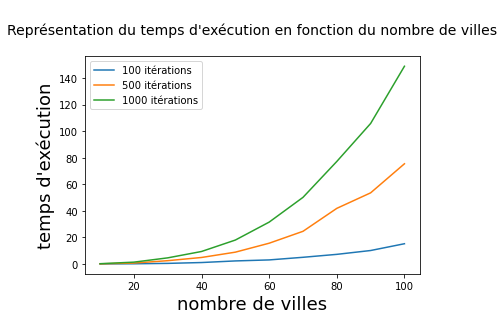

In [31]:
# création des titres sur les axes
plt.xlabel("nombre de villes", fontsize=18)
plt.ylabel("temps d'exécution", fontsize=18)

# on trace les courbes
res = plt.plot(villes, centIt_temps,label='100 itérations')
res2 = plt.plot(villes, cinqcentIt_temps,label='500 itérations')
res3 = plt.plot(villes, milleIt_temps,label='1000 itérations')

# affichage de la légende
plt.legend()

# création du titre du graphique
font2 = {'size':14}
plt.title("\nReprésentation du temps d'exécution en fonction du nombre de villes\n", loc = 'center',fontdict = font2)

Nous avons ensuite calculé les équations de tendances de ces résultats, afin de pouvoir faire des statistiques descriptives. Pour cela, nous avons utilisé la fonction *polyfit* de numpy. Nous avons remarqué que les courbes de tendances les plus justes dans notre cas étaient des courbes polynomiales de degré 3.

Equation de la courbe de tendance pour 100 itérations :
           3            2
2.516e-05 x - 0.001693 x + 0.07451 x - 0.7378

Equation de la courbe de tendance pour 500 itérations :
          3            2
6.86e-05 x + 0.001211 x - 0.06193 x + 0.7827

Equation de la courbe de tendance pour 1000 itérations :
           3            2
0.0001586 x - 0.001545 x + 0.05422 x - 0.3233




Text(0.5, 1.0, "\nReprésentation du temps d'exécution en fonction du nombre de villes\n")

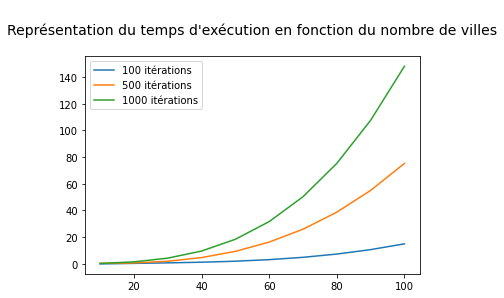

In [32]:
# calcul de l'équation polynomiale pour les temps d'execution de 100 itérations
z = np.polyfit(villes, centIt_temps , 3)
p = np.poly1d(z)
plt.plot(villes,p(villes),label='100 itérations')

print("Equation de la courbe de tendance pour 100 itérations :")
print(p)

# calcul de l'équation polynomiale pour les temps d'execution de 500 itérations
z = np.polyfit(villes, cinqcentIt_temps , 3)
p = np.poly1d(z)

print("\nEquation de la courbe de tendance pour 500 itérations :")
print(p)

plt.plot(villes,p(villes),label='500 itérations') 

# calcul de l'équation polynomiale pour les temps d'execution de 1000 itérations
z = np.polyfit(villes, milleIt_temps , 3)
p = np.poly1d(z)

plt.plot(villes,p(villes),label='1000 itérations')

print("\nEquation de la courbe de tendance pour 1000 itérations :")
print(p)
print("\n")
plt.legend()

font2 = {'size':14}
plt.title("\nReprésentation du temps d'exécution en fonction du nombre de villes\n", loc = 'center',fontdict = font2)

In [33]:
# calcul de l'équation polynomiale pour les temps d'execution de 100 itérations
z = np.polyfit(villes, centIt_temps , 3)
p = np.poly1d(z)

print("Temps pour 1000 villes et 100 itérations :\n")

print(str(p(1000)) + " secondes" )
print(str(p(1000)/60) + " minutes" )
print(str(p(1000)/60/60) + " heures" )

print("\n--------------------------------\n")

print("Temps pour 1000 villes et 500 itérations :\n")
# calcul de l'équation polynomiale pour les temps d'execution de 500 itérations
z = np.polyfit(villes, cinqcentIt_temps , 3)
p = np.poly1d(z)

print(str(p(1000)) + " secondes" )
print(str(p(1000)/60) + " minutes" )
print(str(p(1000)/60/60) + " heures" )

print("\n--------------------------------\n")

print("Temps pour 1000 villes et 1000 itérations :\n")
# calcul de l'équation polynomiale pour les temps d'execution de 1000 itérations
z = np.polyfit(villes, milleIt_temps , 3)
p = np.poly1d(z)

print(str(p(1000)) + " secondes" )
print(str(p(1000)/60) + " minutes" )
print(str(p(1000)/60/60) + " heures" )

Temps pour 1000 villes et 100 itérations :

23535.826904008583 secondes
392.2637817334764 minutes
6.53772969555794 heures

--------------------------------

Temps pour 1000 villes et 500 itérations :

69746.04973078553 secondes
1162.4341621797587 minutes
19.373902702995977 heures

--------------------------------

Temps pour 1000 villes et 1000 itérations :

157084.9813456806 secondes
2618.08302242801 minutes
43.63471704046683 heures


Ces différentes équations nous permettent de prédire le temps d'exécution pour un nombre de villes données.

On peut par exemple prédire que pour 1000 villes avec 500 itérations le temps d'exécution serait de 19h, et pour 1000 villes avec 100 itérations le temps d'exécution serait de 6.5 heures.

Nous avons alors réalisé le test en temps réel afin de vérifier la qualité de ces estimations. Pour cela, nous avons lancé l'algorithme pour 1000 villes et 100 itérations.

Le temps prédictif pour ce calcul était d'environ 6.5h, et le calcul en temps réel dura 5h. Avec ce test, on peut en conclure que notre équation prédictive nous donne une indication plutôt proche de la réalité.

#### &emsp; &emsp; **5.2.3 Écarts de nos solutions par rapport à l'optimal en fonction du nombre de villes**  <a name="5.2.3"></a>

Cette partie est consacrée à l'étude de l'écart avec l'optimal pour les solutions de notre algorithme, en fonction du nombre de villes.

Text(0.5, 1.0, "\nReprésentation de l'écart entre les valeurs renvoyés par notre algorithme et l'optimal\n")

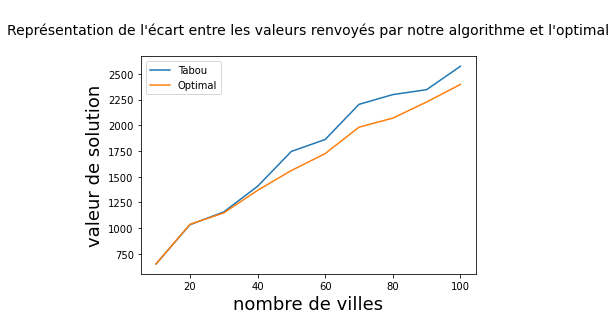

In [34]:
plt.xlabel("nombre de villes", fontsize=18)
plt.ylabel("valeur de solution", fontsize=18)
res = plt.plot(villes, cinqcentIt_tabou_lengraphe,label='Tabou')
res2 = plt.plot(villes, cinqcentIt_opti_lengraphe,label='Optimal')
plt.legend()
font2 = {'size':14}
plt.title("\nReprésentation de l'écart entre les valeurs renvoyés par notre algorithme et l'optimal\n", loc = 'center',fontdict = font2)

Text(0.5, 1.0, "\nReprésentation des écarts entre les valeurs renvoyés par notre algorithme et l'optimal\n")

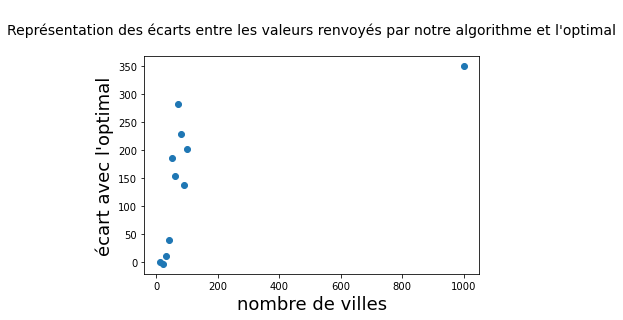

In [35]:
ecart_opti=list()

for i in range(len(villes2)):
    ecart_opti.append(centIt_tabou_lengraphe2[i]-centIt_opti_lengraphe2[i])

plt.xlabel("nombre de villes", fontsize=18)
plt.ylabel("écart avec l'optimal", fontsize=18)
res = plt.plot(villes2, ecart_opti,linestyle='', marker='o')

font2 = {'size':14}
plt.title("\nReprésentation des écarts entre les valeurs renvoyés par notre algorithme et l'optimal\n", loc = 'center',fontdict = font2)

### &emsp;**5.3 Script de tests de montée en charge** <a name="5.3"></a>

Ce code permet d'analyser la capacité de notre algorithme tabou à fonctionner correctement avec des charges de travail plus importantes. Ce script s'arrête lorsque l'obtention d'une solution prend plus de temps de que le temps maximum passé en paramètre. Enfin, le temps pour chaque lancement d'algorithme est affiché avec le nombre de villes pour ce lancement.

In [ ]:
def montee_en_charge(nb_iteration_start, temps_exec_max , nb_ville_start):  

  #Définition des paramètres
    nb_iteration = nb_iteration_start
    liste_temps = []  
    liste_taille = []
    temps = 0
    nb_ville = nb_ville_start
    taille_matrice=nb_ville_start
    
    #La boucle s'effectue jusqu'à ce que le temps d'exécution soit supérieur au temps max
    while ( temps < temps_exec_max  ) :
            graphe = grapheVillesAleatoire(nb_ville,tempsMax) #exécution d'une matrice aléatoire
            start_time = time.time()

            #lancement de l'algorithme tabou
            sol, courants, meilleurs_courants, initial_path = tabu_search(start_node="la rochelle", tabu_length =len(graphe), iter_max = nb_iteration, graphe=graphe, withNearestNeighbor=True)
            stop_time = time.time()
            temps = int(stop_time - start_time) 

            #écrit les valeurs dans les listes (taille et temps)  
            liste_taille.append(taille_matrice)
            liste_temps.append(temps)

            nb_iteration = nb_iteration + 1
            taille_matrice = taille_matrice + 50
            
    #écriture du résultat pour chaque itération        
    for i in range(len(liste_taille)):
        resultat = print(liste_taille[i], "villes", liste_temps[i], "s")
        i+=1

montee_en_charge(10,30,200) 

## **6. Conclusion**  <a name="6"></a>

Pour conclure ce livrable, nous avons donc mis en place nos différents algorithmes en optant pour une combinaison avec un algorithme glouton (plus proche voisin) et un algorithme métaheuristique (recherche tabou) dans le but de générer les solutions les plus optimales possibles.\
Nous avons également mis en place différents cas de tests en faisant varier les paramètres entrées de nos algorithmes (taille de la matrice, nombre d'itérations, taille de la liste tabou, etc.) afin d'étudier les conséquences de ces variations en vue de déterminer les limites et la véracité des algorithmes.